# Work on Healpix of CosmoDC2

- cosmoDC2 : /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image
- author : Sylvie Dagoret-Campagne
- Creation : January 30 th 2021

In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import pyarrow


In [3]:
# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=mesos://vm-75063.lal.in2p3.fr:5050 appName=PySparkShell>
2.4.4


In [4]:
# Spark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

In [5]:
from pyspark.sql.functions import col, pandas_udf 
from pyspark.sql.types import LongType

from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql import functions as F
from pyspark.sql.functions import randn

In [6]:
# here is how we create a function ('Ang2Pix') that can be called by dataframes
# it takes as input the "ra" and "dec" values (which are not very different from theta/phi)
# and returns the pixel number (but as pandas series for efficiency)
import numpy as np
import pandas as pd
import healpy as hp

nside=512

In [7]:
npix = hp.nside2npix(nside)
lmax = 3 * nside

In [8]:
def Ang2Pix_func(ra: pd.Series, dec: pd.Series) -> pd.Series:
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

In [9]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
#gal = gal.withColumn("ihealpix",pd_ang2pix(gal["RA"],gal["DEC"]))

In [10]:
! hadoop dfs -ls /lsst/DC2/cosmoDC2

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Found 5 items
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-12-11 15:12 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-10-16 10:52 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_double.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-04-23 17:28 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_nofaint.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-09-07 19:17 /lsst/DC2/cosmoDC2/shear_cosmoDC2
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-04-16 18:40 /lsst/DC2/cosmoDC2/xyz_v1.1.4_hive


In [11]:
fullfilename="/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image"
datafile=fullfilename


In [12]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()

In [13]:
df = spark.read.format("parquet").load(datafile)

In [32]:
#df.printSchema()

In [15]:
list_of_columns=df.columns
#print(list_of_columns)

# Select galaxies

In [18]:
#df_gal=df.filter('extendedness == true')

In [19]:
df_gal=df

# Healpix

In [20]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
df_gal_healpix = df_gal.withColumn("ihealpix",pd_ang2pix(df_gal["ra"],df_gal["dec"]))

In [21]:
df_gal_healpix_small=df_gal_healpix.select('ra','dec','ihealpix')

In [22]:
df_gal_healpix_small.describe().show()

+-------+-----------------+------------------+------------------+
|summary|               ra|               dec|          ihealpix|
+-------+-----------------+------------------+------------------+
|  count|        324194504|         324194504|         324194504|
|   mean|61.81579482161395|-35.20157446025631|2474106.7133363374|
| stddev|7.671898969807873| 5.873644236053061|131055.99488624082|
|    min|47.73195595578662|-46.60694933341967|           2225472|
|    max|75.97287254648704|-24.59513201507679|           2716447|
+-------+-----------------+------------------+------------------+



In [23]:
m=df_gal_healpix_small.groupBy('ihealpix').count()
m.show(5)

+--------+-----+
|ihealpix|count|
+--------+-----+
| 2585905|10377|
| 2565424|10116|
| 2590005|11011|
| 2589996| 8747|
| 2557232| 9013|
+--------+-----+
only showing top 5 rows



# Plot

In [24]:
# get to python world (to Pandas) : 
# note that here is the action (lazy evaluation so far)
p=m.toPandas()
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34486 entries, 0 to 34485
Data columns (total 2 columns):
ihealpix    34486 non-null int32
count       34486 non-null int64
dtypes: int32(1), int64(1)
memory usage: 404.3 KB


/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


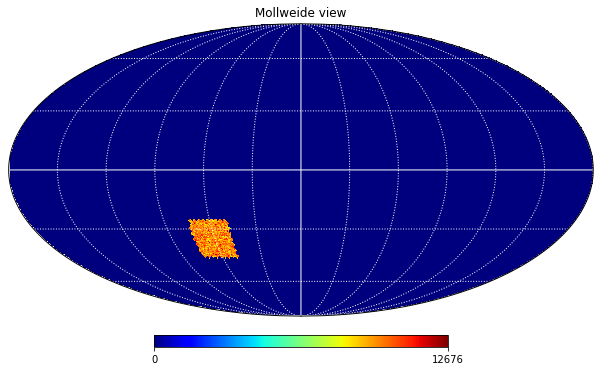

In [25]:
# the following doesn't has anything to do with spark (only Healpix)
hpMap = np.zeros(hp.nside2npix(nside))
#fill the map from the pandas object
hpMap[p['ihealpix'].values]=p['count'].values
#plot using standard healpy function
hp.mollview(hpMap,cmap="jet")
hp.graticule(color='white')

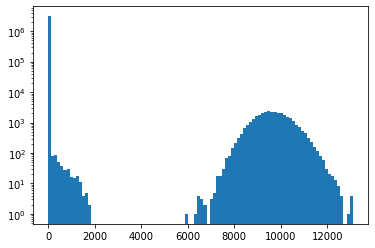

In [26]:
plt.hist(hpMap,bins=int(100))
plt.yscale('log')
plt.show()

In [28]:
cl = hp.anafast(hpMap)
ell = np.arange(len(cl))

Text(0.5, 1.0, 'DC2Run2.2i : $C_\\ell$ by healpix/anafast')

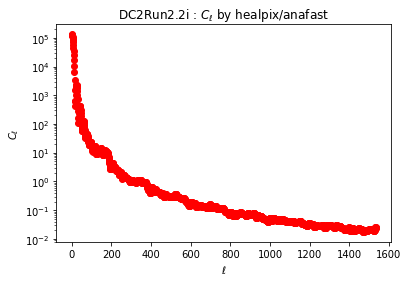

In [29]:
plt.plot(ell,cl,"ro")
plt.yscale('log')
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")
plt.title("{} : $C_\ell$ by healpix/anafast".format("DC2Run2.2i"))

In [30]:
lmax 

1536

In [31]:
hpMap.shape

(3145728,)